In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
cd /content/drive/MyDrive/DAI_Project/DAI

/content/drive/MyDrive/DAI_Project/DAI


In [14]:
from utils import latent_vector
# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model, load_model # for assembling a Neural Network model
from keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Flatten, Dropout # for adding layers
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, LeakyReLU # for adding layers
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version

# Other utilities
import sys
import os

Tensorflow/Keras: 2.12.0
numpy: 1.22.4
matplotlib: 3.7.1
graphviz: 0.20.1


4/4 [==============================] - 1s 129ms/step


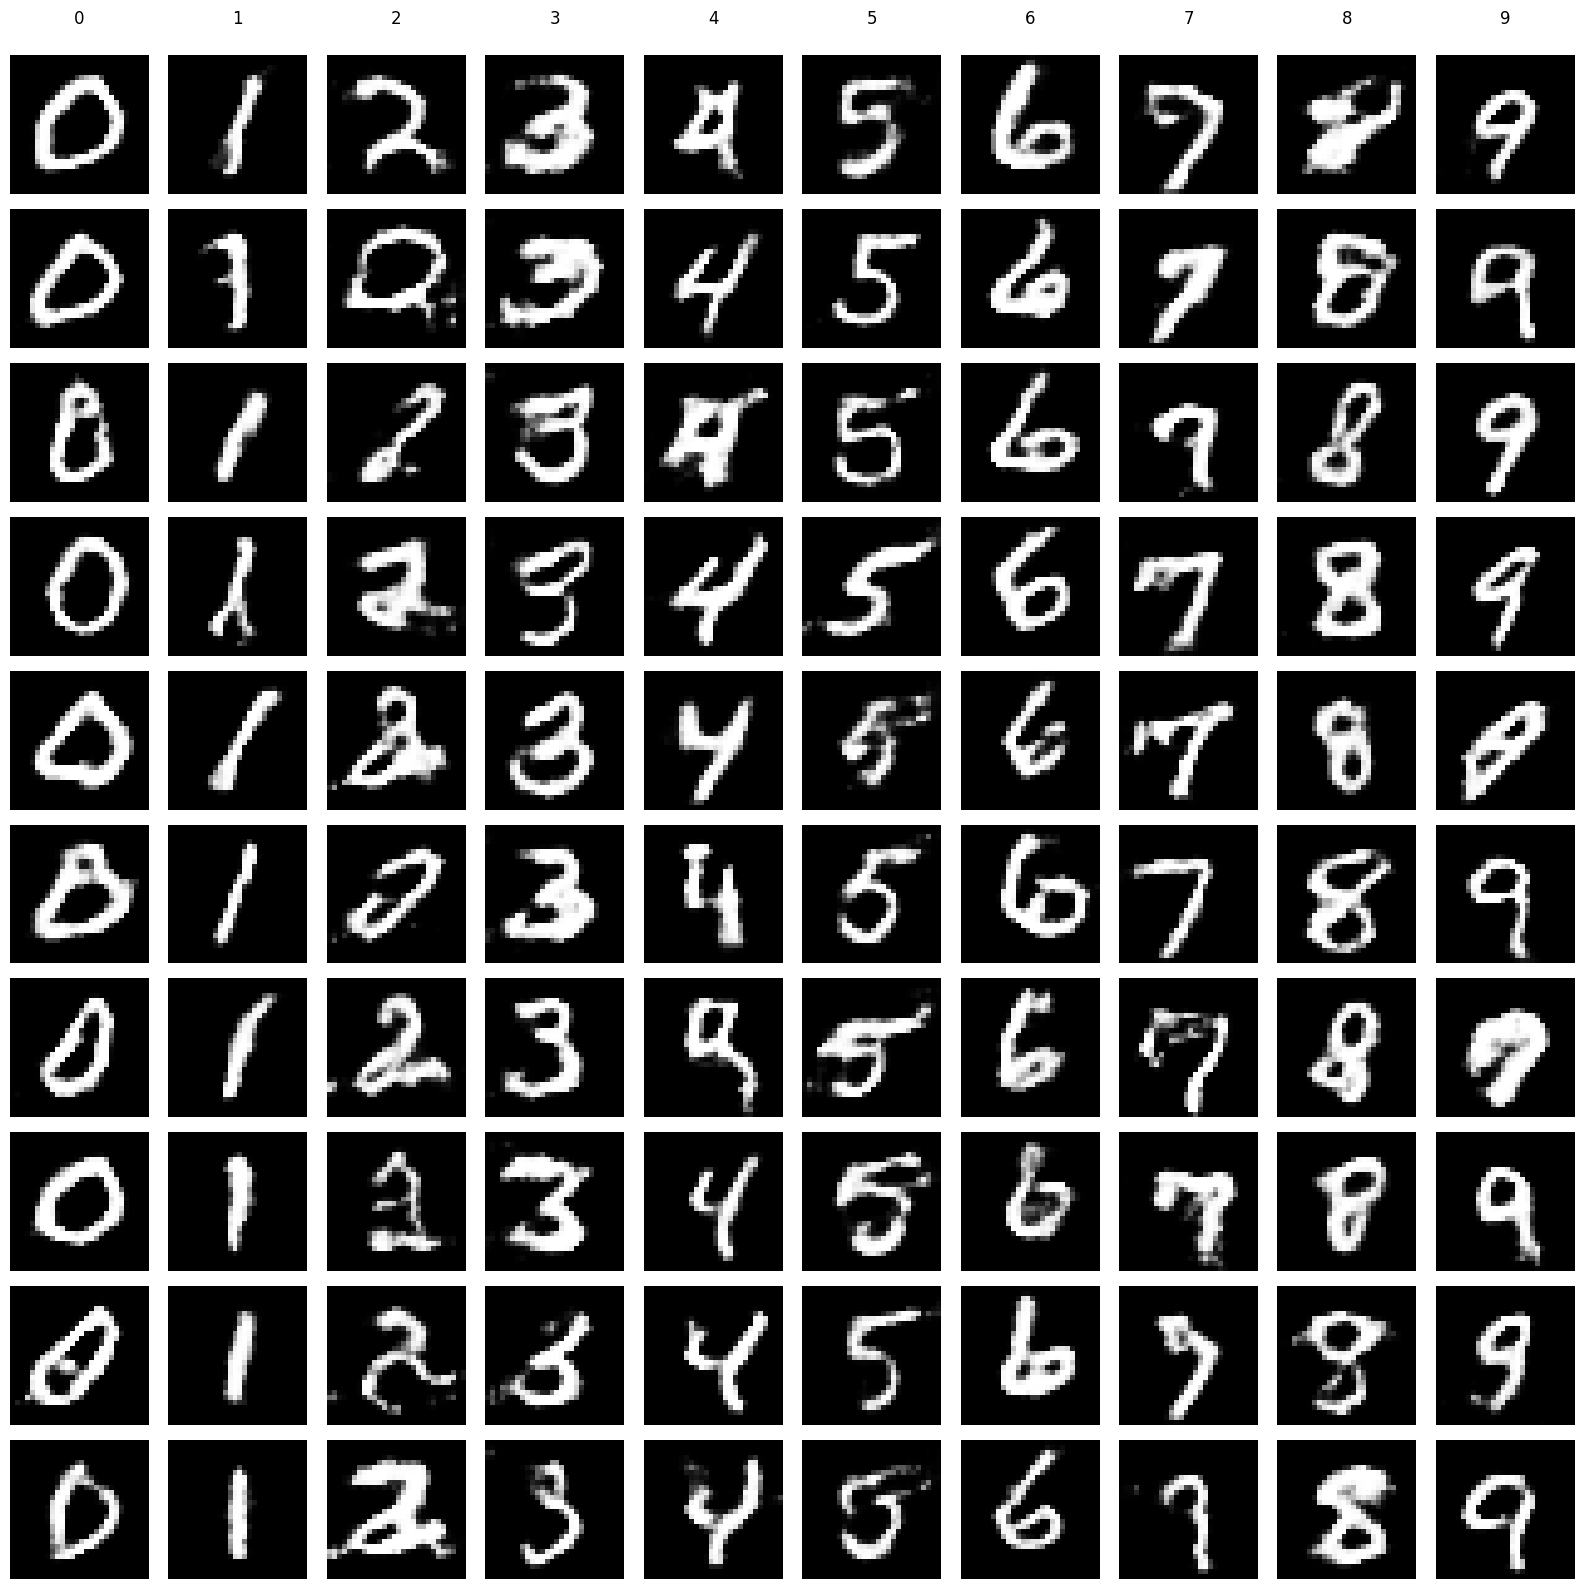

In [15]:
DIGIT = 2

latent_points, _ = latent_vector(100, 100)

# Specify labels that we want (0-9 repeated 10 times)
labels = np.asarray([x for _ in range(10) for x in range(10)])

# Load previously saved generator model
model = load_model('data/cgan_generator.h5')

# Generate images
gen_imgs  = model.predict([latent_points, labels])

# Scale from [-1, 1] to [0, 1]
gen_imgs = (gen_imgs + 1) / 2.0

# Display images
fig, axs = plt.subplots(10, 10, sharey=False, tight_layout=True, figsize=(16,16), facecolor='white')
k=0
for i in range(0,10):
    for j in range(0,10):
        axs[i,j].matshow(gen_imgs[k], cmap='gray')
        axs[0,j].set(title=labels[k])
        axs[i,j].axis('off')
        k=k+1
plt.show()

In [16]:
# Define a function that computes the sensitivity of the output to each weight for a given input x
def get_weight_sensitivities(model, x):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)
        output = model(x)
    gradients = tape.gradient(output, model.trainable_weights)
    sensitivities = []
    for i in range(len(model.trainable_weights)):
        weight = model.trainable_weights[i]
        gradient = gradients[i]
        sensitivity = tf.multiply(gradient, weight)
        sensitivities.append(sensitivity)
    return sensitivities

# Define a function that creates a mask for the top x% most sensitive weights
def create_mask_for_top_k_percent(sensitivities, k):
    # Compute the absolute value of the sensitivity for each weight
    abs_sensitivities = [tf.abs(s) for s in sensitivities]
    # Flatten the sensitivities into a single 1D tensor
    flat_sensitivities = tf.concat([tf.reshape(s, [-1]) for s in abs_sensitivities], axis=0)
    # Compute the threshold value for the top k% most sensitive weights
    num_weights = tf.size(flat_sensitivities)
    k_percent_index = tf.cast(tf.round(tf.multiply(tf.cast(num_weights, tf.float32), tf.divide(tf.cast(k, tf.float32), 100))), tf.int32)
    threshold = tf.nn.top_k(flat_sensitivities, k_percent_index).values[-1]
    # Create a binary mask indicating which weights are in the top k% most sensitive
    mask = [tf.cast(tf.greater_equal(tf.abs(s), threshold), tf.float32) for s in sensitivities]
    return mask

In [17]:
latent_points, _ = latent_vector(100, 100)

# Specify labels that we want (0-9 repeated 10 times)
labels = np.asarray([DIGIT for _ in range(100)])

print(labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [18]:
# Compute the sensitivity of the output to each weight for the example input x
sensitivities = get_weight_sensitivities(model, [latent_points, labels])

# Create a mask for the top 10% most sensitive weights
mask = create_mask_for_top_k_percent(sensitivities, 0.01)

# Prune the weights corresponding to the mask by setting them to zero
pruned_weights = [tf.multiply(w, 1 - m) for w, m in zip(model.trainable_weights, mask)]
# Alternatively, you can set the pruned weights to a small constant value instead of zero to avoid numerical issues
#pruned_weights = [tf.multiply(w, tf.cast(tf.greater(m, 0), tf.float32)) + tf.multiply(tf.constant(1e-8), tf.cast(tf.equal(m, 0), tf.float32)) for w, m in zip(model.trainable_weights, mask)]

# Set the pruned weights in the model
model.set_weights(pruned_weights)

4/4 [==============================] - 1s 142ms/step


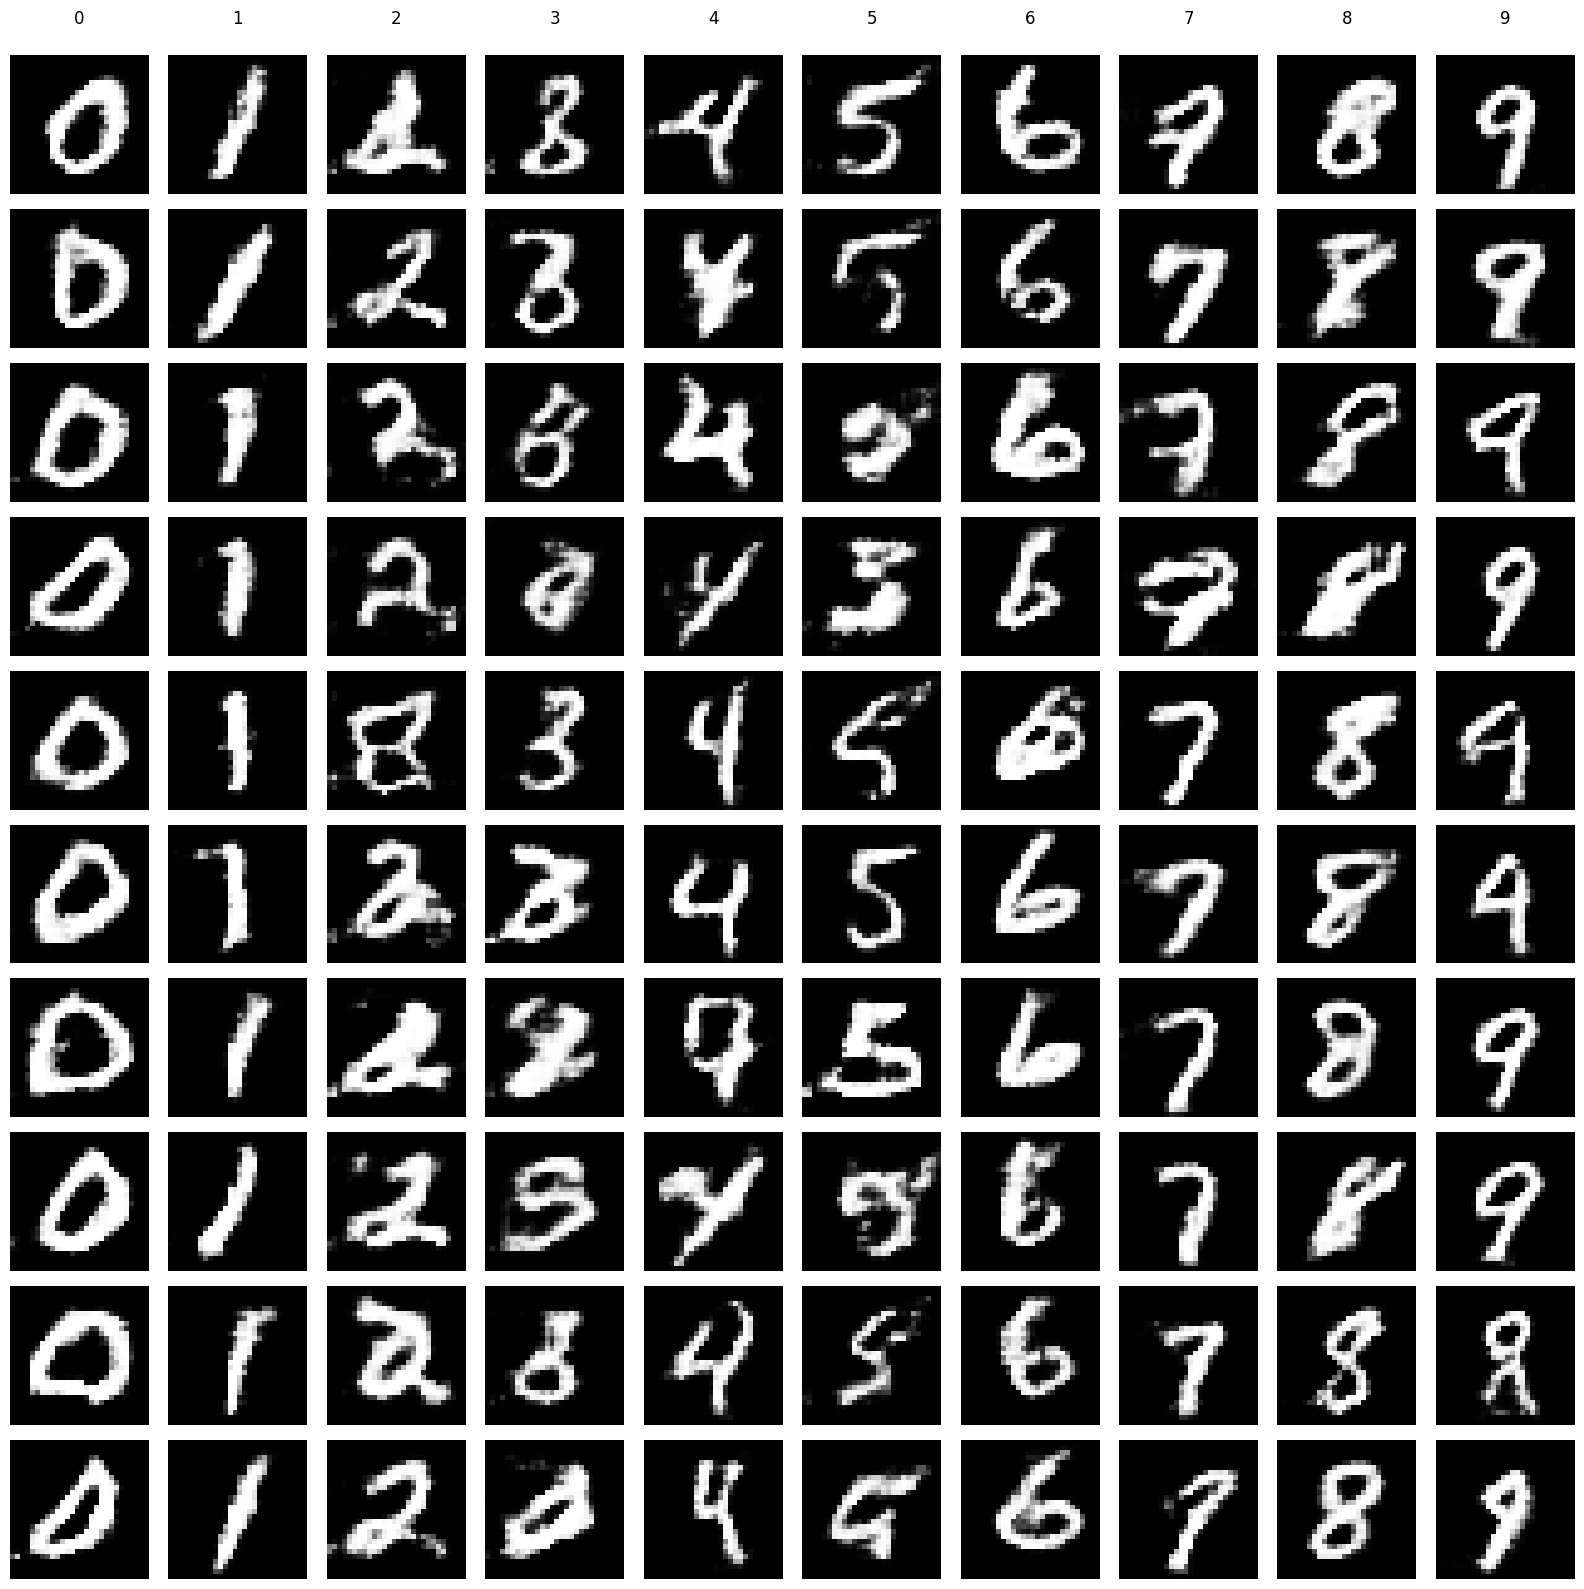

In [8]:
latent_points, _ = latent_vector(100, 100)

# Specify labels that we want (0-9 repeated 10 times)
labels = np.asarray([x for _ in range(10) for x in range(10)])

# Generate images
gen_imgs  = model.predict([latent_points, labels])

# Scale from [-1, 1] to [0, 1]
gen_imgs = (gen_imgs + 1) / 2.0

# Display images
fig, axs = plt.subplots(10, 10, sharey=False, tight_layout=True, figsize=(16,16), facecolor='white')
k=0
for i in range(0,10):
    for j in range(0,10):
        axs[i,j].matshow(gen_imgs[k], cmap='gray')
        axs[0,j].set(title=labels[k])
        axs[i,j].axis('off')
        k=k+1
plt.show() 

In [9]:
model = load_model('data/cgan_generator.h5')

In [10]:
sensitivities = []

latent_points, _ = latent_vector(100, 100)

for i in range(10):
    labels = np.asarray([i for _ in range(100)])
    sensitivity = get_weight_sensitivities(model, [latent_points, labels])

    sensitivities.append(sensitivity)

In [11]:
def prune_weights_for_input(model, x_index, sensitivities, k_percent):
    """
    Prunes weights for a specific input x in a model based on the sensitivities for all inputs

    Args:
        model: A tensorflow model object
        x_index: The index of the input x in the model's input layer
        sensitivities: A list of sensitivity arrays for each input to the model
        k_percent: The percentage of top scoring weights to keep

    Returns:
        The model with pruned weights
    """
    # Get the sensitivity array for the specified input x
    sensitivity_x = sensitivities[x_index]

    # Calculate the score for each weight
    score = np.abs(sensitivity_x) - (1 / (len(sensitivities) - 1)) * np.sum(np.abs(sensitivities[:x_index] + sensitivities[x_index + 1:]), axis=0)

    # Choose the top k_percent scoring weights and create a binary mask
    threshold = 1
    print(score.shape)
    mask = np.where(score >= threshold, 1, 0)

    # Prune the weights by setting the corresponding values in the weight tensor to 0
    for i, w in enumerate(model.trainable_weights):
        w.assign(tf.multiply(w, tf.cast(1 - mask[i], dtype=tf.float32)))

    return model


In [16]:
model = prune_weights_for_input(model, 0, sensitivities, 5)

<ipython-input-15-6b7a0e277646>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score = np.abs(sensitivity_x) - (1 / (len(sensitivities) - 1)) * np.sum(np.abs(sensitivities[:x_index] + sensitivities[x_index + 1:]), axis=0)


(11,)


ValueError: ignored